# Compressed Sensing Example: MNIST Digit Lightweight Classifier
### Import statements and notebook settings

In [37]:
import copy
import time

from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

show_mnist_plots = True

### Plotting helper functions

In [38]:
def plot_heat_map(coef_arr, lambda_labels, fig_size_x=12, fig_size_y=12):
    """Plot heat maps (plural) for all coef in coef_arr

    Args:
        coef_arr (List[np.array]): List of 2D np arrays containing coef to plot
        lambda_labels (List[float]): List of lambda values to label plots. Must have length equal to coef_arr
    """
    plt.rcParams['figure.figsize'] = [fig_size_x, fig_size_y]
    if isinstance(coef_arr, (list)) is False:
        coef_arr = [coef_arr]
    if isinstance(lambda_labels, (list)) is False:
        lambda_labels = [lambda_labels]

    fig,axs = plt.subplots(len(lambda_labels),1)
    if len(lambda_labels) == 1:
        axs = [axs]
    for j, coef in enumerate(coef_arr):
        # x = coef.coef_
        x_pcolor = axs[j].pcolor(coef,cmap='hot')
        fig.colorbar(x_pcolor, ax=axs[j])
        axs[j].set_ylabel(f"lambda={lambda_labels[j]}") 
    return


def plot_confusion(model_coef, test_data, test_label, lambda_val, comp_factor=0, fig_size=12):
    plt.rcParams['figure.figsize'] = [fig_size, fig_size*0.8]
    pred = test_data@model_coef.T
    
    conf_pred = np.argmax(pred, axis=1)
    conf_mat = confusion_matrix(test_label, conf_pred, normalize='pred')
    disp = ConfusionMatrixDisplay(conf_mat)
    disp.plot()
    title = f"Lambda = {lambda_val}"
    if comp_factor:
        title = title + f"; Compression = {comp_factor:.2f}%"
    plt.title(title)
    plt.show()
    return


### Import MNIST data and vectorize the data
Each of the images is vectorized (28*28 pixel image is converted to 784 element vector) and combined into a single array (see data labeled with `_A`). One-hot encoding is used to create the solution matrix from the labels (see data labeled with `_B`).

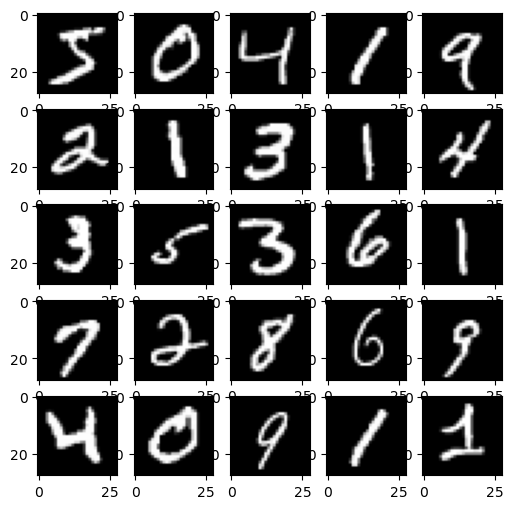

In [39]:
fig_size = 6
plt.rcParams['figure.figsize'] = [fig_size,fig_size]

(train_data, train_label), (test_data, test_label) = mnist.load_data()

if show_mnist_plots:
    mnist_plots = (5)**2     # set to be squared number
    root_mnist = int(np.sqrt(mnist_plots))
    fig, axs = plt.subplots(root_mnist, root_mnist)
    for i in range(mnist_plots):
        axs[i//root_mnist, i%root_mnist].imshow(train_data[i], cmap=plt.get_cmap('gray'))
    plt.show()

num_labels = 10     # set equal to number of labels (digits)

def one_hot(labels, num_labels):
    """return array of one-hot encoding to match number of labels"""
    return np.eye(num_labels)[np.array(labels).reshape(-1)]

def vectorize_data(data, label, num_labels):
    """flatten each image in data into 1D array and create one-hot encoding result matrix"""
    data_vector = data.reshape(data.shape[0], -1)
    label_vector = one_hot(label, num_labels)
    return data_vector, label_vector

train_A, train_B = vectorize_data(train_data, train_label, num_labels)
test_A, test_B = vectorize_data(test_data, test_label, num_labels)

### Solve $AX=B$ using Lasso regularization
For this example, $AX=B$ is an overdetermined system, where $A$ is the matrix of vectorized images and $B$ is the solution matrix created using one-hot encoding from the labels. Lasso regularization is used to find an approximate solution to the system of equations and is shown in the following equation.

\begin{equation}
\hat{X} = min||AX - B||_2 + \lambda||X||_1 
\end{equation}

where $||\cdot||_1$ is the L1 norm, $||\cdot||_2$ is the L2 norm, $\lambda$ is the regularization factor, and $\hat{X}$ is the approximate solution for $X$.

Larger values of $\lambda$ will increase the cost function such that more values of $\hat{X}$ will be 0. This incentivizes a sparse solution useful for compressed sensing.

The results show that as $\lambda$ is increased, the number of non-zero elements decreases. The heatmaps visualize the $\hat{X}$ data for each $\lambda$, where the x-axis displays the weights for each pixel and the y-axis displays the weights for each label (or digit).

iter 0: lambda = 0.0001	solve time: 228.1 sec	non-zero elem: 6730	iterations: 731.1
iter 1: lambda = 0.01	solve time: 78.5 sec	non-zero elem: 4093	iterations: 331.2
iter 2: lambda = 0.1	solve time: 44.7 sec	non-zero elem: 2247	iterations: 219.3
iter 3: lambda = 0.5	solve time: 33.5 sec	non-zero elem: 1180	iterations: 191.8


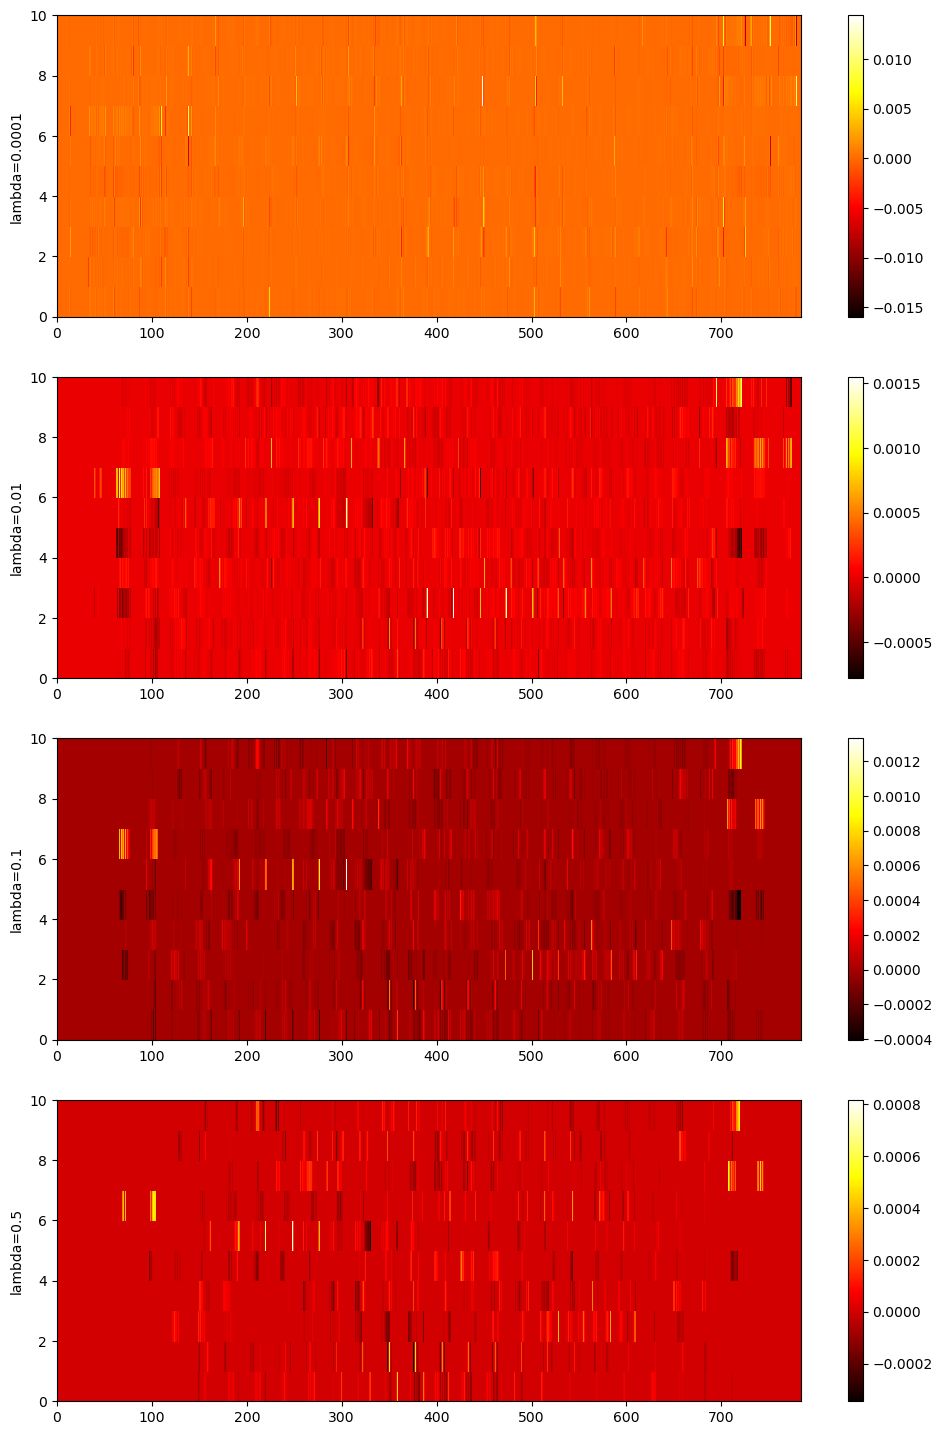

In [40]:
# lambda is regularization factor in Lasso algo
lambda_array = [1e-4, 1e-2, 1e-1, 0.5]

def generate_models(A, b, lambda_array):
    model_list = []
    for i, lam in enumerate(lambda_array):
        start = time.time()
        if lam==0:
            clf = linear_model.LinearRegression(fit_intercept=False)
        else:
            clf = linear_model.Lasso(alpha=lam, 
                                     fit_intercept=False, 
                                     warm_start=True, 
                                     selection='random',
                                    #  max_iter=200
                                     )
        clf.fit(A, b)
        elapsed = time.time() - start
        print(f"iter {i}: lambda = {lam}\t"
              f"solve time: {elapsed:3.1f} sec\t"
            #   f"non-zero elem: {np.count_nonzero(clf.coef_)}\t"
            #   f"iterations: {np.average(clf.n_iter_)}"
              )
        model_list.append(clf)
    return model_list

clf_array = generate_models(train_A, train_B, lambda_array)

plot_heat_map([model.coef_ for model in clf_array], lambda_array, fig_size_y=18)

plt.show()

### Classification Report
As shown below, the f1-score does not change (much) with the increasing value of $\lambda$

In [41]:
def disp_classification_report(model, test_data, test_label, lambda_val, label_list, print_all=False):
    print(f"Classification report:\t"
          f"lambda: {lambda_val}\t"
          f"iterations: {np.average(model.n_iter_)}\t"
          f"elements: {np.count_nonzero(model.coef_)}")
    model_coef = model.coef_
    build_classification_report(model_coef, test_data, test_label, lambda_val, label_list, print_all)
    return

def build_classification_report(model_coef, test_data, test_label, lambda_val, label_list, print_all=False):
    pred = test_data@model_coef.T
    pred_val = np.argmax(pred, axis=1)
    if print_all:
        print(classification_report(test_label, pred_val, labels=label_list))
    else:
        report = classification_report(test_label, pred_val, labels=label_list, output_dict=True)
        report_df = pd.DataFrame(data=report).round(2)
        col_mask = ["accuracy","macro avg","weighted avg"]
        print(f"{report_df.drop(labels='support').get(col_mask).transpose()}\n")
    return

labels = [i for i in range(10)]
for i, clf in enumerate(clf_array):
    disp_classification_report(clf, test_A, test_label, lambda_array[i], labels)

Classification report:	lambda: 0.0001	iterations: 731.1	elements: 6730
              precision  recall  f1-score
accuracy           0.85    0.85      0.85
macro avg          0.85    0.85      0.85
weighted avg       0.85    0.85      0.85

Classification report:	lambda: 0.01	iterations: 331.2	elements: 4093
              precision  recall  f1-score
accuracy           0.85    0.85      0.85
macro avg          0.86    0.85      0.85
weighted avg       0.86    0.85      0.85

Classification report:	lambda: 0.1	iterations: 219.3	elements: 2247
              precision  recall  f1-score
accuracy           0.85    0.85      0.85
macro avg          0.85    0.85      0.85
weighted avg       0.85    0.85      0.85

Classification report:	lambda: 0.5	iterations: 191.8	elements: 1180
              precision  recall  f1-score
accuracy           0.84    0.84      0.84
macro avg          0.84    0.84      0.83
weighted avg       0.84    0.84      0.84



### Confusion Matrix
The confusion matrix is plotted showing the TPR along the diagonal. The FPR is shown on all other elements. The data has been normalized in order to show the precision of the model

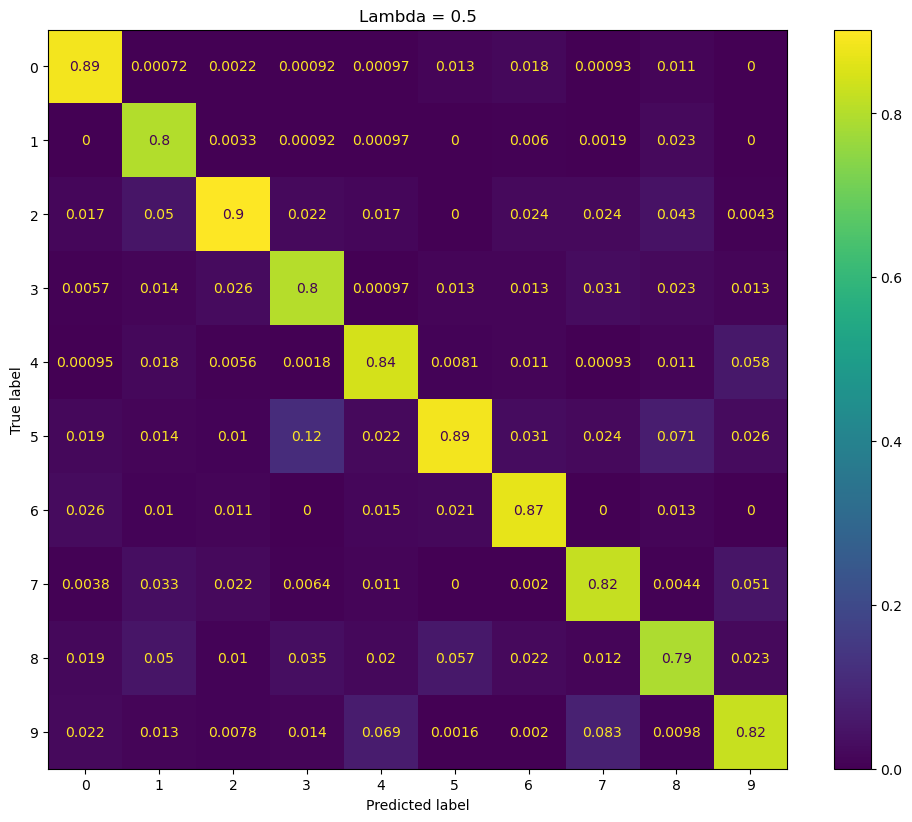

In [42]:
model_ind = 3
lambda_val = lambda_array[model_ind]
model = clf_array[model_ind]
model_coef = model.coef_
plot_confusion(model_coef, test_A, test_label, lambda_val)


### Further Model Compression
The model can be further compressed by zero-ing the smallest coefficients. The number of non-zero coefficients should be kept above ~10% of the total coefficients in $\hat{X}$ to keep the f1-score high.

In [51]:
# Compress model for selected lambda
def compress_model(coef,threshold):
    """compress model by zeroing all coefficients below threshold, 
    where the threshold is defined as the percentage of the max coef
    """
    
    threshold_val = coef.max()*threshold
    comp_coef = copy.deepcopy(coef)
    comp_coef[np.abs(comp_coef) < threshold_val] = 0
    return comp_coef

def compress_model_by_row(coef,threshold):
    """compress model by zeroing all coefficients below threshold by row, 
    where the threshold is defined as the percentage of the max coef per row
    """
    threshold_val = coef.max(axis=1)*threshold
    comp_coef = copy.deepcopy(coef)
    comp_coef[np.abs(comp_coef) < threshold_val[:, np.newaxis]] = 0
    return comp_coef

def disp_comp_model_stats(base_model, comp_model, lambda_val, plot_heat_map=False, plot_conf=False):
    """Helper function to display common data for compressed models"""
    base_elem = np.count_nonzero(base_model)
    comp_model_elem = np.count_nonzero(comp_model)
    comp_factor = 1 - comp_model_elem/base_elem
    print(f"# of non-zero elements in compressed model: {comp_model_elem} (Compression: {comp_factor:.2f}%)")
    if plot_heat_map: plot_heat_map(comp_model, lambda_val, fig_size_y=4)
    if plot_conf: plot_confusion(comp_model, test_A, test_label, lambda_val, comp_factor=comp_factor)

base_elem = np.count_nonzero(model_coef)
print(f"# of non-zero elements in base model: {base_elem}")

threshold = 0.03
# comp_model_abs = compress_model(model_coef, threshold)
# disp_comp_model_stats(model_coef, comp_model_abs, lambda_val)
comp_model_by_row = compress_model_by_row(model_coef, 2*threshold)
disp_comp_model_stats(model_coef, comp_model_by_row, lambda_val)
build_classification_report(comp_model_by_row, test_A, test_label, lambda_val, labels)

comp_model_by_row_too_scarce = compress_model_by_row(model_coef, 4*threshold)
disp_comp_model_stats(model_coef, comp_model_by_row_too_scarce, lambda_val)
build_classification_report(comp_model_by_row_too_scarce, test_A, test_label, lambda_val, labels)





# of non-zero elements in base model: 1180
# of non-zero elements in compressed model: 824 (Compression: 0.30%)
              precision  recall  f1-score
accuracy           0.83    0.83      0.83
macro avg          0.83    0.82      0.82
weighted avg       0.83    0.83      0.82

# of non-zero elements in compressed model: 575 (Compression: 0.51%)
              precision  recall  f1-score
accuracy           0.79    0.79      0.79
macro avg          0.81    0.78      0.77
weighted avg       0.81    0.79      0.77



### References
*Data Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control* by Steve L. Brunton and J. Nathan Kutz